
<h2 style="text-align:center;" > Estudio de viabilidad en la delimitación de coberturas con imágenes satelitales mediante el modelo Segment Anything: Comparación con la metodología CORINE Land Cover en el municipio de Guatavita.</h2>

<h2 style="text-align:center;" >Tutorial Descarga de imagenes y procesamiento</h2>

Autores:
*   **Cristian Stiven Florez Macias**
*   **Sergio Andres Escobar Eslava** 

##  Indice
1. [INSTALACIÓN DE PAQUETES](#packages)
2. [IMPORTAR PAQUETES](#import)
3. [AUTENTICACION](#auth)
4. [ZONA DE ESTUDIO](#area)
5. [DESCARGAR IMAGEN SENTINEL](#sentinel)
6. [PROCESAMIENTO IMAGEN SENTINEL](#setting)


<a name="packages"></a>

## 1. INSTALACIÓN DE PAQUETES

Para este proyecto es necesario el uso de paquetes, por lo caul se hace uso del comando `pip install` si observamos se le agrega un `!` para ejecutar la linea de codigo sobre la terminal del sistema o `%` para ejecutar el administrador de paquetes pip dentro del kernel actual, lo anterior con el fin de instalar paquetes externos que aportan diversas funciones dentro del proyecto para este caso son:

* **Earth Engine**: Es un paquete de python que permite la integracion con la plataforma en la nube de Google, mediante el lenguaje de programacion python permite realizar el analisis y procesamiento de las imagenes satelitales usadas en el proyecto.
* **Geemap**: Es un paquete de python de codigo abierto que hace mas interactivo el analisis geoespacial y visualizacion con earth engine, nos brinda herramientas para la visualizacion de imagenes y capas.
* **Geopandas**: Es un paquete de python de codigo abierto pensado para facilitar las operaciones con tipos geometricos (Punto, Multi-punto, Linea, Multi-linea, Poligono y Multi-poligono).
* **Rasterio**: Es un paquete de python de codigo abierto que facilita la lectura y escritura de formatos para almacenar datos raster mediante una API de python que se apoya en matrices N-dimensionales y geojson.
* **eeconvert**: Es un paquete en python aun en version pre alpha que se usa para realizar conversiones desde formatos empleados em Google Earth Engine a formatos SIG como GeoDataframes, es importante en el proyecto para convertir la region de un archivo GeoDataFrame a un archivo compatible con EarthEngine como featureCollection.

In [ ]:
%pip install -q geemap geopandas rasterio eeconvert

<a name="import"></a>

## 2. IMPORTAR PAQUETES

Los paquetes en python son una excelente opcion para estructurar los modulos realizados en python, nos permite cargar un "módulo A.B designa un submódulo B en un paquete llamado A."(pythondocs, s.f) por ejemplo tomamos el multimodulo a: geemap con su modulo b: eefolium y le designamos un submodulo emap, esto nos da la posibilidad de no preocuparnos por nombres duplicados en nuestro proyecto.


In [ ]:
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import geojson
import eeconvert as eec
import matplotlib.gridspec as gridspec
from skimage import exposure
import rasterio
import numpy as np

### Creacion de una funcion parametrizada para imprimir los graficos usados en el cuaderno
A continuacion se plante la creacion de una función nonbrada `plot_map` que permite visualizar los mapas generados en el cuaderno a partir de datos guardados en el tipo GeoDataFrame, esta funcion separa en dos partes la salida grafica:
* En el lado derecho se imprime el titulo de la salida grafica ademas de el grafico con la grilla georreferenciada con sus respectivas unidades y del
* En el lado izquierdo se imprime informacion de la institucion, leyenda del mapa, sistema de referencia y escala del mapa.

In [16]:
def plot_map(gdf, title, projection, legend_label='Leyenda', scale='1:10000'):
    """
    Grafica los mapas con los elementos de la leyenda personalizados.

    Parámetros:
        gdf (GeoDataFrame): GeoDataFrame de GeoPandas que contiene la geometría y los atributos a graficar.
        title (str): Título del mapa principal.
        projection (str o CRS): Proyección espacial del GeoDataFrame.
        legend_label (str): Nombre de la columna del GeoDataFrame que se usará para la simbologia y la leyenda.

    Descripción:
        Esta función grafica un mapa con una leyenda lateral personalizada y ajusta la posición de la leyenda de categorías a la derecha del gráfico principal. Además, muestra información institucional y de proyección en el panel lateral derecho.
    """
    fig = plt.figure(figsize=(14, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])
    
    # Grilla 1: Mapa principal
    ax_map = fig.add_subplot(gs[0, 0])
    gdf.plot(legend_label, ax=ax_map, legend=True)
    ax_map.set_title(title, fontsize=14, pad=18, fontweight='bold')
    ax_map.set_xlabel('Longitud (°)')
    ax_map.set_ylabel('Latitud (°)')
    
    legend = ax_map.get_legend()
    legend.set_bbox_to_anchor((1.25, 0.5))
    legend.set_title('shapeName')
    
    # Grilla 2: Leyenda
    ax_legend = fig.add_subplot(gs[0, 1])
    ax_legend.axis('off')
    ax_legend.text(0.2, 0.95, 'Universidad Distrital', fontsize=12, fontweight='bold', ha='center', va='top')
    ax_legend.text(0.2, 0.90, 'Francisco José de Caldas', fontsize=12, fontweight='bold', ha='center', va='top')
    ax_legend.text(0.2, 0.1, projection, fontsize=10, ha='center', va='center')
    ax_legend.text(0.2, 0.15, f'Escala: {scale}', fontsize=10, ha='center', va='center')

    plt.show()

<a name="import"></a>

## 3. AUTENTICACIÓN
Antes de iniciar debemos estar registrados en Google Engine y crear un nuevo proyecto.El termino de autenticacion se refiere al proceso por el cual se va a realizar el inicio de sesion mediante el cliente de python a Google Earth Engine, esta funcion usa el estandar OAuth2.0 y genera un token persistente almacenado en nuestra maquina local o el servicio de Google Collab, el metodo inicializar toma el token persistente y carga nuestro proyecto de Google Drive en la maquina local.

In [8]:
ee.Authenticate()
ee.Initialize(project='ee-adam-segmentation')


Successfully saved authorization token.


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


<a name="import"></a>

# 4. ZONA DE ESTUDIO

Descripcion realizada en la monografia

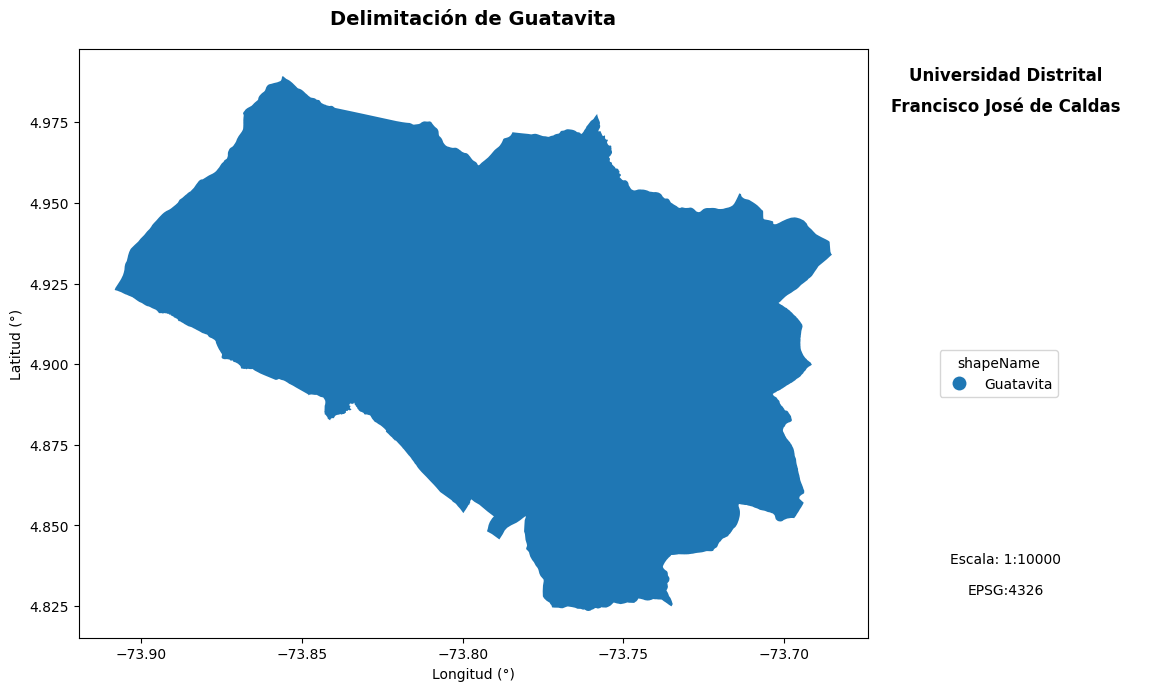

In [9]:
ISO = 'COL' # "COL" es el codigo ISO para Colombia
ADM = 'ADM2' # Equivalente a distritos administrativos

# Busqueda de geoBoundaries mediante el servicio    
url = f"https://www.geoboundaries.org/api/current/gbOpen/{ISO}/{ADM}"
r = requests.get(url)
download_path = r.json()["gjDownloadURL"]

# Guardado del resultado en formato GeoJSON en nuestra carpeta usada para guardar este tipo de archivos
filename = '../geojson/geoboundary.geojson'
geoboundary = requests.get(download_path).json()
with open(filename, 'w') as file:
   geojson.dump(geoboundary, file)

# Leer los datos con GeoPandas
geoboundary = gpd.read_file(filename)
shape_name = 'Guatavita'
guatavita = geoboundary[geoboundary.shapeName == shape_name]
# Imprimimos la zona de estudio para guatavita
plot_map(
    guatavita,
    title=f"Delimitación de {shape_name}",
    projection=guatavita.crs,
    legend_label="shapeName"
)
guatavita.to_file('../geojson/guatavita.geojson', driver='GeoJSON')

# Obtener la geometría de forma para Boyaca
centroid = guatavita.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(guatavita) #geodataframe a feature collection

<a name="import"></a>

# 5. DESCARGAR IMAGEN SENTINEL

Proporciona imágenes ópticas terrestres de alta resolución para servicios terrestres (por ejemplo, monitorización de la vegetación, la cobertura de suelo y agua, las vías navegables interiores y las zonas costeras). También ayudará a los servicios de emergencia con la información que captura. El primer satélite Sentinel-2A fue exitosamente lanzado el 23 de junio de 2015. El segundo Sentinel-2B fue lanzado el 7 de marzo de 2017, ambos a bordo del vehículo de lanzamiento Vega, desde el Puerto espacial de Kourou. Cuenta con un sensor MSI () captura 12 bandas espectrales con una Resolucion radiometrica de 12 bits sin embargo los recursos en google earth engine contiene informacion en 16 bits.

| Banda   | Descripción                           | Longitud de onda (μm) | Resolución Espacial (m) | 
|---------|---------------------------------------|-----------------------| ------------------------|
| Banda 1 | Aerosol                               | 0.43 – 0.45           | 60                      |
| Banda 2 | Azul                                  | 0.45 – 0.52           | 10                      |
| Banda 3 | Verde                                 | 0.54 – 0.57           | 10                      |
| Banda 4 | Rojo                                  | 0.65 – 0.68           | 10                      |
| Banda 5 | Borde Rojo 1                          | 0.69 – 0.71           | 20                      |
| Banda 6 | Borde Rojo 2                          | 0.73 – 0.74           | 20                      |
| Banda 7 | Borde Rojo 3                          | 0.77 – 0.79           | 20                      |
| Banda 8 | Infrarrojo Cercano (NIR) 1            | 0.78 – 0.90           | 10                      |
| Banda 8A| Infrarrojo Cercano (NIR) 2            | 0.85 – 0.87           | 20                      |
| Banda 9 | Vapor de agua                         | 0.93 – 0.95           | 60                      |
| Banda 10| Cirrus                                | 1.36 – 1.39           | 60                      |
| Banda 11| SWIR 1                                | 1.56 – 1.65           | 20                      |
| Banda 12| SWIR 2                                | 2.10 – 2.28           | 20                      |

el cubrimiento de las imagenes sentinel es:
* **Para productos de nivel 0, nivel 1A y nivel 1B**: Tienen 25 km a través de la pista x 23 km.
* **Para productos ortorrectificados (Nivel-1C y Nivel-2A)**: La imagen se divide en mosaicos de 100x100 km2 . Los productos Level-1C y Level-2A se pone a disposición de los Usuarios.



In [10]:
def generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2021-01-01',
    max_date='2024-12-31',
    range_min=0,
    range_max=2000,
    cloud_pct=10
):

    """Generamos una imagen de Sentinel-2 utilizando la API de Python 
    para Google Earth Engine filtrada por nubes, mediana agregada

    Argumentos:
      region (ee.Geometry): La geometría del área de interés a filtrar.
      product (str): ID activo de Earth Engine
       Puede encontrar la lista completa de ID de ImageCollection
        en https://developers.google.com/earth-engine/datasets
      min_date (str): Fecha mínima para adquirir colección de imágenes satelitales
      max_date (str): Fecha maxima para adquirir colección de imágenes satelitales
      range_min (int): Valor mínimo para el rango de visalización
      range_max (int): Valor maximo para el rango de visalización
      cloud_pct (float): El porcentaje de cobertura de nubes por el que filtrar (predeterminado 10)

    La funcion retorna:
      ee.image.Image: La imagen generada de Sentinel-2 recortada en la región de interés
    """

    #Generar compuesto agregado mediano
    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
        .median()

    # Obtener las bandas RGB
    image = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)
    # Tener en cuenta que el valor máximo de las bandas RGB está establecido en 65535
    # porque las bandas de Sentinel-2 son enteros de 16 bits
    # con un rango numérico completo de [0, 65535] (el máximo es 2^16 - 1);
    # Sin embargo, los valores reales son mucho más pequeños que el valor máximo.
    # Fuente: https://stackoverflow.com/a/63912278/4777141

    return image.clip(region)

In [11]:
# Generacion de imagen RGB usando GEE
image = generate_image(
    region,
    product='COPERNICUS/S2_SR_HARMONIZED', # Sentinel-2A
    min_date='2018-01-01', # Obtener todas las imagenes entre el inicio de 2018
    max_date='2018-12-31', # Obtener todas las imagenes hasta el final de 2018
    cloud_pct=10, # Filtrar imágenes con cobertura de nubes >= 10.0%
)
# Descargar imagen
output_path = '../tiff/sentinel_guatavita.tif'
geemap.ee_export_image(
    image,
    filename=output_path,
    region=region.geometry(),
    scale=10,
    crs='EPSG:4326'
)
# Visualizar mapa
Map = geemap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image, {}, 'Sentinel2')
Map.addLayerControl()
Map

Generating URL ...
Please wait ...
Data downloaded to c:\Users\Cristian\Desktop\Trabajos U\DEFINITIVO-Proyecto de grado\tiff\sentinel_guatavita.tif


Map(center=[4.911587171903614, -73.78648564510542], controls=(WidgetControl(options=['position', 'transparent_…

<a name="setting"></a>

# 5. PROCESAMIENTO IMAGEN SENTINEL


## Análisis de histogramas

El histograma es un gráfico que muestra la distribución de frecuencias de un conjunto de datos.
En este caso, la imagen es un arreglo de números, por lo que
nuestro conjunto de datos sería la imagen. Los números en el eje X representan los valores de los píxeles y en el eje Y su respectiva frecuencia.

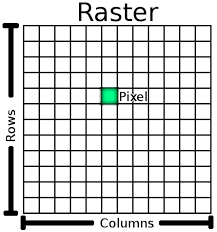

La visualizacion y analisis del histograma nos permite conocer que procesos pueden ayudar a realizar una mejor interpretación de la imagen como tomar la decicion de efectuar un realce que nos permita distinguir las características para la zona de estudio.

In [12]:
# Cargamos la imagen y separamos sus bandas en archivos por separado
dir_image = "../tiff/sentinel_guatavita.tif"
image = rasterio.open(dir_image)
profile = image.profile
img_red = image.read(1)
img_green = image.read(2)
img_blue = image.read(3)

# Calculamos el histograma de cada banda
co_green,ce_green = exposure.histogram(img_green)
co_blue,ce_blue = exposure.histogram(img_blue)
co_red,ce_red = exposure.histogram(img_red)

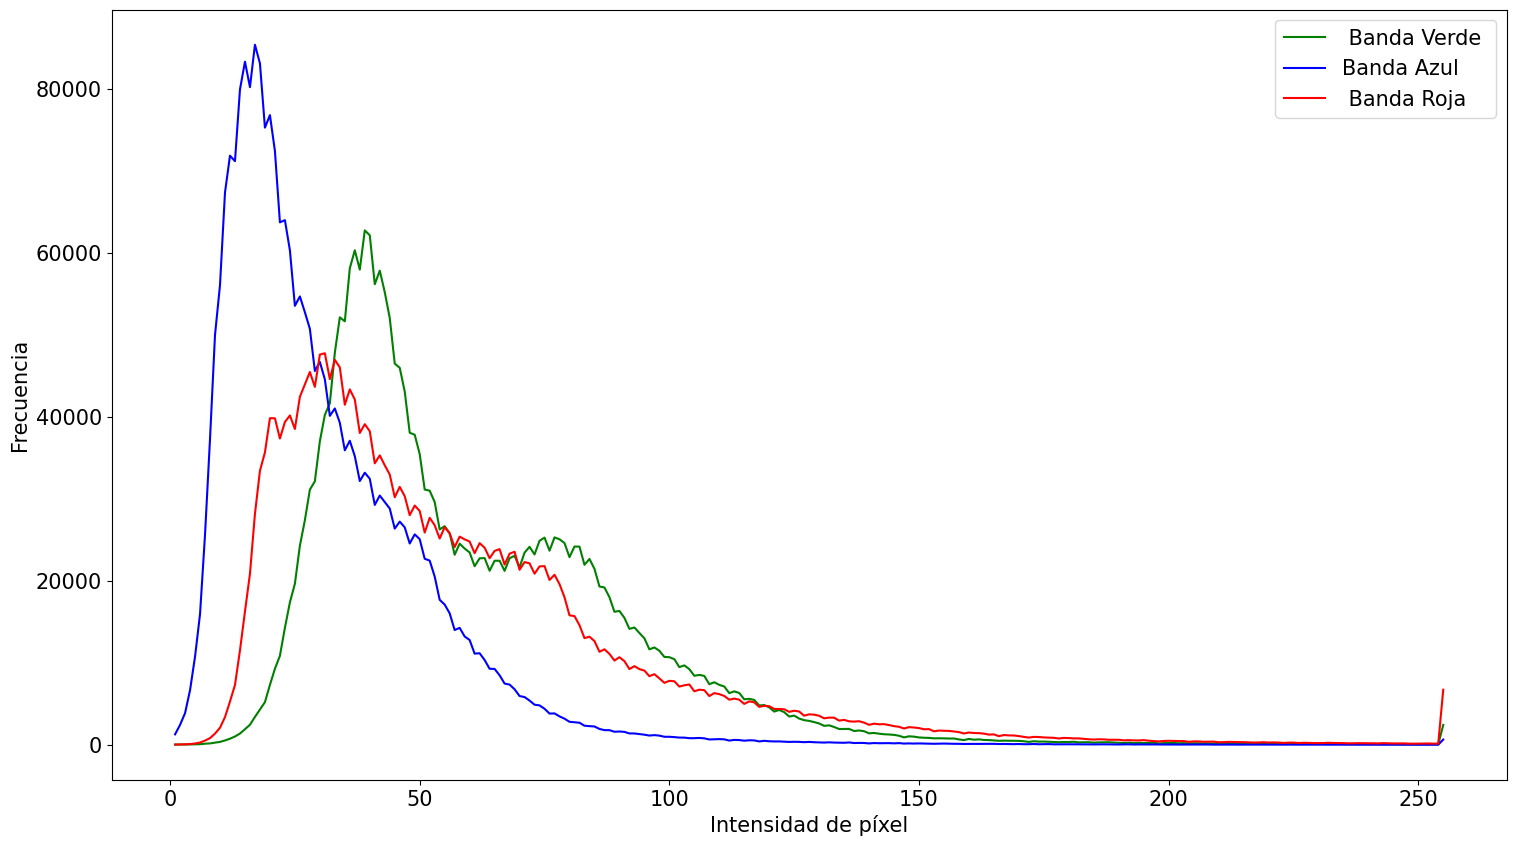

{'Rojo': {'min': np.uint8(0), 'max': np.uint8(255), 'mean': np.float64(31.78406551926611), 'std': np.float64(39.50765006466394)}, 'Verde': {'min': np.uint8(0), 'max': np.uint8(255), 'mean': np.float64(33.41242059830559), 'std': np.float64(37.22930764102113)}, 'Azul': {'min': np.uint8(0), 'max': np.uint8(255), 'mean': np.float64(17.00331104112493), 'std': np.float64(21.6056878145317)}}


In [23]:
fig , ax = plt. subplots ( figsize =(18 , 10))
ax.plot( ce_green [1::] , co_green [1::] , "g" , label =" Banda Verde ")
ax.plot( ce_blue [1::] , co_blue [1::] ,"blue",label ="Banda Azul" )
ax.plot( ce_red [1::] , co_red [1::] ,"red",label =" Banda Roja" )
plt.legend(loc="upper right", fontsize=15)
plt.xlabel("Intensidad de píxel", fontsize=15)
plt.ylabel("Frecuencia", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
## Estadísticas básicas de cada banda
stats = {
    "Rojo": {
        "min": img_red.min(),
        "max": img_red.max(),
        "mean": img_red.mean(),
        "std": img_red.std()
    },
    "Verde": {
        "min": img_green.min(),
        "max": img_green.max(),
        "mean": img_green.mean(),
        "std": img_green.std()
    },
    "Azul": {
        "min": img_blue.min(),
        "max": img_blue.max(),
        "mean": img_blue.mean(),
        "std": img_blue.std()
    }
}
print(stats)

Mediante el resultado anterior mapeamos las estadisticas basicas presentes en la imagen con lo cual obtenemos

| Banda | Mínimo | Máximo | Media | Desviación Estándar |
|-------|--------|--------|-------|-------------------|
| **Rojo** | 0 | 255 | 31.78 | 39.51 |
| **Verde** | 0 | 255 | 33.41 | 37.23 |
| **Azul** | 0 | 255 | 17.00 | 21.61 |

De acuerdo con la tabla anterior las medias de las bandas nos indica que predominan los tonos oscuros en la imagen.

 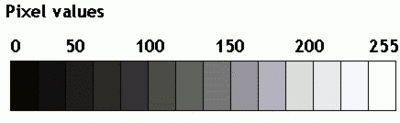

## Realce de imágenes satelitales

Los realces se usan para mejorar la interpretacion visual de las imagenes, mediante el metodo rescale_intensity se puede lograr reducir o estirar los valores de intensidad presentes en la imagen, esta funcion acepta como entrada el rango deseado a estirar o reducir y ademas se establece el rango de salida. Mediante este metodo no se alteran los valores de pixel de la imagen solo se modifica la forma de visualizacion.

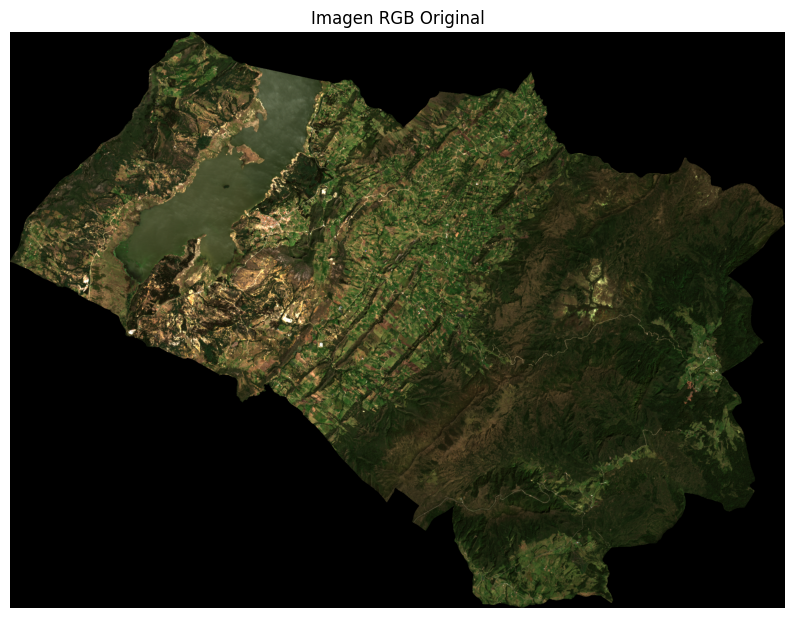

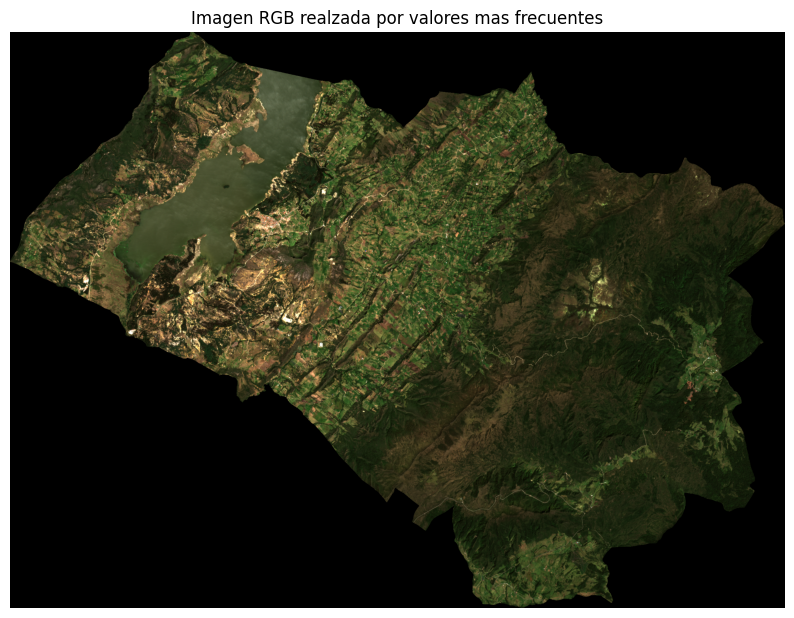

In [29]:
new_red = exposure.rescale_intensity(img_red, in_range=(0, 255), out_range=(0, 255))
new_green = exposure.rescale_intensity(img_green, in_range=(0, 255), out_range=(0, 255))
new_blue = exposure.rescale_intensity(img_blue, in_range=(0, 255), out_range=(0, 255))


# unimos de nuevo las capas
old_rgb = np.dstack((img_red, img_green, img_blue))
new_rgb = np.dstack((new_red, new_green, new_blue))

# visualizamos la imagen Original
plt.figure(figsize=(10, 10))
plt.imshow(old_rgb.astype(np.uint8))
plt.title('Imagen RGB Original')
plt.axis('off')
plt.show()

# visualizamos la imagen con el realce
plt.figure(figsize=(10, 10))
plt.imshow(new_rgb.astype(np.uint8))
plt.title('Imagen RGB realzada por valores mas frecuentes')
plt.axis('off')
plt.show()
# Descargar imagen 
output_path = "../tiff/sentinel_guatavita_realzada.tif"
profile.update(dtype=rasterio.uint8, count=3)
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(new_red.astype(np.uint8), 1)
    dst.write(new_green.astype(np.uint8), 2)
    dst.write(new_blue.astype(np.uint8), 3)